In [1]:
import numpy as np
import scipy
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import plotnine as p9

from functools import partial

The gravity model is likely one of the most empirically successful theories in modern economics. In some sense one could consider it the „fundamental law“ of economic geography, as most of the field can be somehow related to it. It is also, in my experience, mostly unknown outside academia, especially compared to some empirically much less successful theories. 

Say we want to describe the trade flows, denominated in terms of their value in some currency, between different countries (or cities, or any other geographic entity). Taking the point of view of a particular country, the gravity model asserts that:

- It will trade more with big and rich countries (i.e. countries with a large total GDP) than with poorer and smaller countries 
- It will trade more with close neighbors and less with far-away countries

## A simple statement of the gravity model

In notation, we have:

$t_{ij} = \frac{G_i G_j}{D_{ij}}$

where:

- $t_{ij}$ is the trade flow between country i and country j
- $G_i$: is the GDP (expressed in some fixed currency) of country i
- $D_{ij}$ is the distance between country i and country j, in whatever unit

Usually, we want to allow a bit more freedom in the exact functional form of the relationship, so we add parameters $\beta_1, \beta_2, \beta_3$:

$t_{ij} = \frac{G_i^{\beta_1} G_j^{\beta_2}}{D_{ij}^{\beta_3}}$

From there, it becomes somewhat obvious why this theory is called Gravity. The GDP of a country is like its mass: richer, bigger countries exert more of a „force“ that attracts trade. However, this attraction decays as a function of distance.

This being said, the functional form above is somewhat awkward to apply to real data, because it involves a division. It is much easier to take the log of both sides, which transforms it into a simple regression equation:

$\log t_{ij} = \alpha + \beta_1 \log G_i + \beta_2 \log G_j + \beta_3 \log D_{ij} $

It is also important to note a few other things here:

- This formulation of gravity is symmetric, so it cannot generate unbalanced trade. We will thus use it to predict total trade between countries (i.e. the sum of imports and exports, also called the turnover). 
- In many scenarios, the best figure for GDP to use is the one computed using Purchasing Power Parity (PPP). Gravity is an exception: here, for once, we want the GDP in USD (or some other currency).

We can now test this model empirically. For this purpose, will use trade data from Germany from 2019 and try to predict German trade with other countries. In other words, we will estimate the model:

$\log t_{j} = \alpha + \beta_2 \log G_j + \beta_3 \log D_{j} $

where:

- $t_{j}$ is the total trade flow between Germany and country j
- $D_{j}$ is the distance between Germany and country j, in whatever unit (we will use km)

## Empirical test: German trade in 2019

To perform our empirical test, we have to do some data crunching first. We already have World Bank data of trade and GDP in the Data folder. To compute the distances, we will use the geopandas example shape file with the countries of the world.

### Import data

In [10]:
world_path = geopandas.datasets.get_path('naturalearth_lowres')
world_df = geopandas.read_file(world_path)
# from World Bank
gdp_df = pd.read_csv("Data/Gravity/gdp_current_dollar.csv")
# from World Bank, WITS
trade_df = pd.read_csv("Data/Gravity/germany_trade.tsv",sep="\t")

### Compute centroids of each country

In [11]:
plt.rcParams["figure.figsize"] = (12,12)

If we use the geographical coordinates to compute centroids, the results will be slightly strange. This is because the geopandas centroid algorithm does not accont for the curvature of the earth. As a quick fix, we first project onto a flat map (using an area preservig projection, in this case CEA), then compute the centroids on this flat map, and then project back onto longitude/latitude.

<AxesSubplot: >

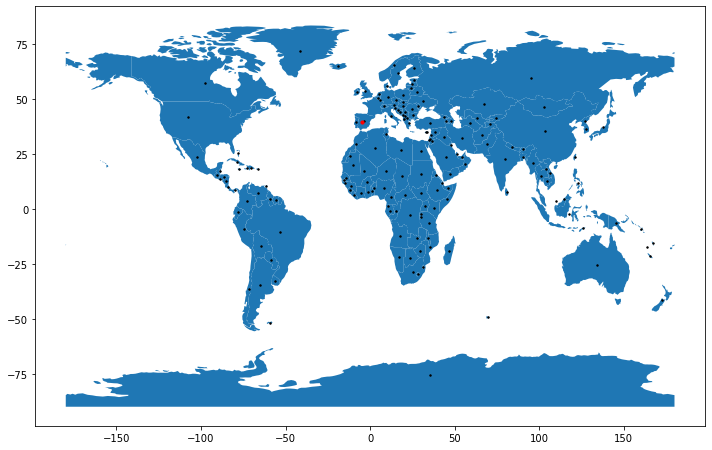

In [12]:
world_df["centroid"] = world_df.to_crs('+proj=cea').centroid.to_crs(world_df.crs)
# lets plot
ax = world_df["geometry"].plot()
world_df["centroid"].plot(ax=ax, color="black",markersize=2)
world_df.query('name == "France"')["centroid"].plot(ax=ax, color="red",markersize=10)

We see that some centroids looks strange. This likely due to overseas territories (e.g. Hawaii for the US). For France (in red), this deviation is particularly visible. Because we will analyze German trade, France is somewhat important to get right,so we will manually fix this:

<AxesSubplot: >

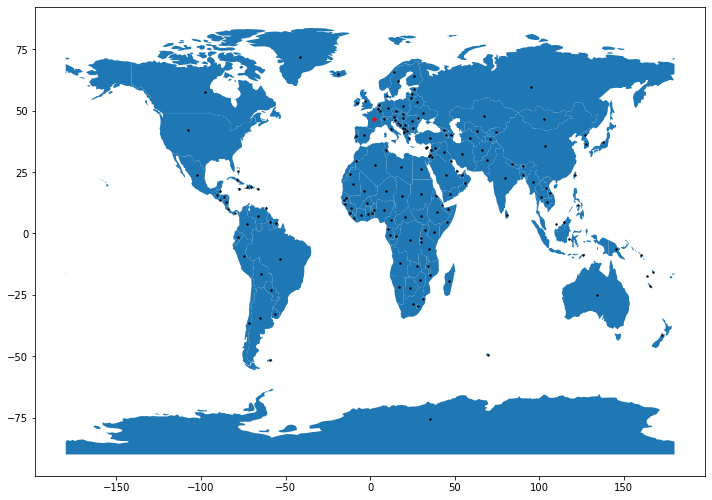

In [13]:
# First we select the right geometry (the one representing the french "mainland", i.e. the hexagone)
hexagone_poly = [x for x in world_df.query('name == "France"')["geometry"].iloc[0].geoms][1]
# We replace with this Polygon
fr_idx = world_df.query('name == "France"').index[0]
world_df.at[fr_idx, "geometry"] = hexagone_poly
# Now we recompute the centroids and replot
world_df["centroid"] = world_df.to_crs('+proj=cea').centroid.to_crs(world_df.crs)
# lets plot
ax = world_df["geometry"].plot()
world_df["centroid"].plot(ax=ax, color="black",markersize=2)
world_df.query('name == "France"')["centroid"].plot(ax=ax, color="red",markersize=10)

### Compute the distance between centroids

We will compute the distance between centroids manually, using the great cricle distance. This assumes that the earth is a sphere, which is of course not the case. However, for what we are doing here, we do not need too much precision - the centroids are already a very rough approximation!

In [14]:
def great_circle_distance(lat1, lon1, lat2, lon2, radius = 6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    angle = np.arccos(np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(lon1 - lon2))
    return angle*radius

# Note that the centroid geometries have longitude in x and latitude in y
lon_ger = world_df.query('name == "Germany"')["centroid"].iloc[0].x
lat_ger = world_df.query('name == "Germany"')["centroid"].iloc[0].y
    
great_circle_germany = partial(great_circle_distance, lat_ger, lon_ger)

In [15]:
world_df["dist"] = world_df["centroid"].apply(lambda x: great_circle_germany(x.y, x.x))

### Merge with the gdp and trade data

In [16]:
# Compute total trade with Germany (Exports + Imports)
trade_df["total_trade"] = trade_df[['Export (US$ Thousand)', 'Import (US$ Thousand)']].sum(axis=1)
# Rename and merge
trade_df = trade_df.rename(columns={"Partner Name":"wb_name"})
gdp_df = gdp_df.rename(columns={"Country Name":"wb_name","2019 [YR2019]":"GDP", "Country Code":"iso_a3"})
merged_df = gdp_df[["wb_name","GDP","iso_a3"]].merge(world_df[["name","dist","iso_a3"]], on="iso_a3")
merged_df = trade_df[["wb_name","total_trade"]].merge(merged_df,on="wb_name")
# We have a few countries with unknown GDP, we remove those
merged_df = merged_df.query('GDP != ".."')

### Log-scale and estimate the model

In [17]:
merged_df["log_trade"] = np.log(merged_df["total_trade"])
merged_df["log_gdp"] = np.log(merged_df["GDP"].astype("float"))
merged_df["log_dist"] = np.log(merged_df["dist"])

In [18]:
gravity_model = smf.ols(formula='log_trade ~ log_gdp + log_dist', data=merged_df).fit()

### Analysing the results

As we fitted a simple linear regression, the easiest way to assess the goodness of fit is with the explained variance, i.e. the R-squared:

In [19]:
gravity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_trade   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     857.2
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           1.67e-83
Time:                        20:52:25   Log-Likelihood:                -183.43
No. Observations:                 155   AIC:                             372.9
Df Residuals:                     152   BIC:                             382.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.2131      1.113     -5.580      0.000      -8.413      -4.013
log_gdp        1.1488      0.033     34.840      0.000       1.084       1.214
log_dist      -1.0172      0.071    -14.275      0.000      -1.158      -0.876
==============================================================================
Omnibus:                        4.745   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.396
Skew:                           0.317   Prob(JB):                        0.111
Kurtosis:                       3.529   Cond. No.                         457.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

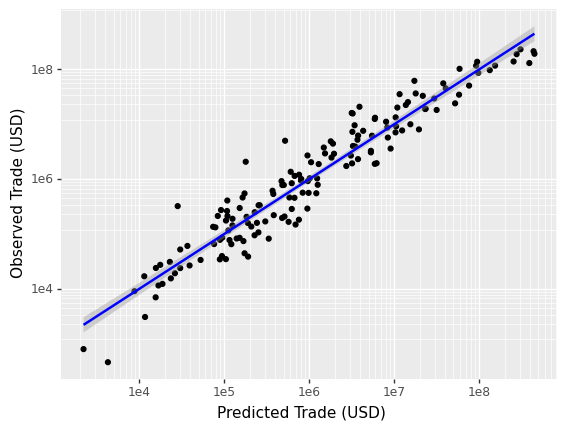

<ggplot: (8755072136424)>

In [24]:
preds = gravity_model.predict()
plot_df = pd.DataFrame({"Predicted Trade (USD)":np.exp(preds),"Observed Trade (USD)":merged_df["total_trade"]})

(p9.ggplot(data=plot_df,mapping=p9.aes(x="Predicted Trade (USD)", y= "Observed Trade (USD)"))
 + p9.geom_point()
 + p9.scale_x_log10()
 + p9.scale_y_log10()
 + p9.geom_smooth(color="blue", method="lm")
)

This is indeed a very good fit: 92% of variance in German trade can be predicted by a model with only two parameters. Pretty amazing!

Note also that the parameters are close to 1 for GDP and -1 for distance. So the best fitting model is close to the very simple unparametrized gravity.

This being said, it is important to note that GDP is doing most of the work here: it alone will explain 80% of variance. However, if we only use GDP to predict trade, this will overpredict trade with far-away countries and underestimate trade with close neighbours:

In [44]:
gdp_model = smf.ols(formula='log_trade ~ log_gdp', data=merged_df).fit()
gdp_model.rsquared

0.8093955636579807

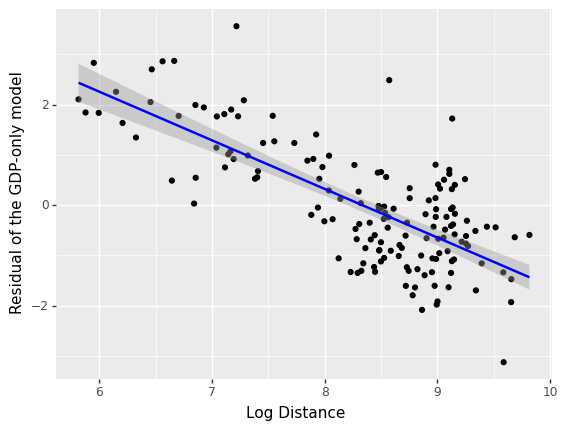

<ggplot: (8755069858898)>

In [47]:
residual = merged_df["log_trade"] - preds
merged_df["gdp_residual"] = residual

(p9.ggplot(data=merged_df,mapping=p9.aes(x="log_dist", y= "gdp_residual"))
 + p9.geom_point()
 + p9.geom_smooth(color="blue", method="lm")
 + p9.labs(x="Log Distance",y="Residual of the GDP-only model")
)

It should be noted here that we took some shortcuts. There are better ways to estimate gravity models than this simple log-linear OLS. For more details, see: https://doi.org/10.1016/B978-0-444-54314-1.00003-3